# Experiment One: 

In the first experiment, we assume that the latent state dynamics match are those assumed by the derivation of VKF. That is, that the latent state at time $t$ is given by 

$$s_t = s_{t-1}+e_t,$$

where $e_t$ is a noise term drawn from $\mathcal{N}(0,z_t^{-1}).$ 
The precision $z_t$ is updated according to 

$$z_t = Rz_{t-1}\varepsilon_t,$$

where $R \geq 1$ is a constant and $\varepsilon_t$ is a random variable drawn from a beta distribution governed by 

$$p(\varepsilon_t) = \mathcal{B}(\varepsilon_t \vert \eta\nu, (1-\eta)\nu),$$

where $\eta = R^{-1}$ and $\nu \geq 0$ is a constant parameter. 


In [1]:
from vkf import VKF
import numpy as np 
from scipy.stats import beta
import matplotlib.pyplot as plt

In [2]:
def make_plot(x,y=None,x_label='Trials',y_label=None,fig_size=(12,10),color='blue'): 
    
    #plot
    plt.figure(figsize=fig_size)
    plt.plot(x,color=color)
    plt.xlabel(x_label) 
    if plt.ylabel != None: plt.ylabel(y_label)
    plt.grid()
    
    #show
    plt.show()

In [3]:
import numpy as np
from scipy.stats import beta

def volatile_walk(T=500, sig2=0.1, l=0.001, s0=10, z0=10, seed=None):
    
    # set seed 
    if seed is not None:
        np.random.seed(seed)
    
    #initialize observations and state
    latent_state = np.zeros(T)
    observations = np.zeros(T)
    ipv = np.zeros(T) # inverse process variance (precision) 
    
    #first step
    latent_state[0] = s0
    observations[0] = s0 + np.random.normal(0, np.sqrt(sig2)) 
    ipv[0] = z0 
    
    #generate state and observations 
    for i in range(1, T):
        
        #update state
        latent_std_t = np.sqrt(1 / ipv[i-1])
        latent_state[i] = np.random.normal(latent_state[i-1], latent_std_t)
        
        #update observation
        observations[i] = latent_state[i] + np.random.normal(0, np.sqrt(sig2))
        
        #update_noise
        epsilon_t = (beta.rvs(1 - l, l)) / (1 - l)
        ipv[i] = ipv[i-1] * epsilon_t
    
    return observations, latent_state, ipv

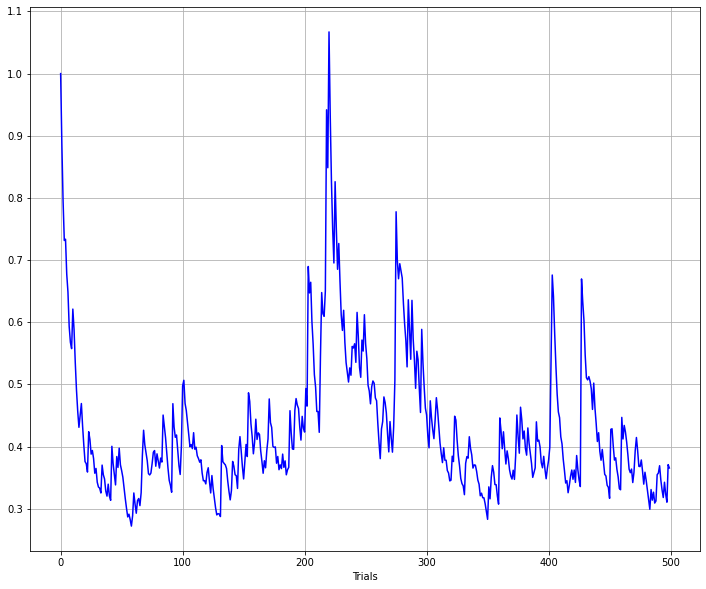

In [4]:
observations,ls,ipv = volatile_walk(seed=12)
signals = VKF(observations)
make_plot(signals['volatility'])



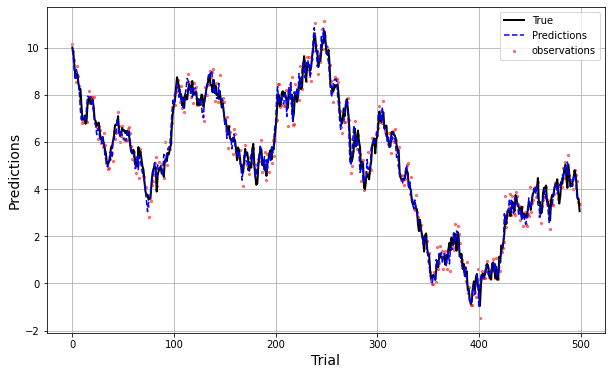

In [5]:
#extract relevant valuess 
m = signals['predictions']
vol = signals['volatility'] 
lr = signals['learning_rate']

#set up plot 
plt.figure(figsize=(10,6)) 
plt.plot(ls,label='True', color='black', linewidth=2)
plt.grid()
plt.xlabel('Trial', fontsize=14)

#plot observations
plt.scatter(range(len(observations)), observations, label='observations', color='red', alpha=0.5, s=5)
plt.ylabel("Predictions", fontsize=14)
plt.plot(m[2:], label='Predictions', color='blue', linestyle='--')
plt.legend()
plt.savefig('Figures/exp1_walk.png')


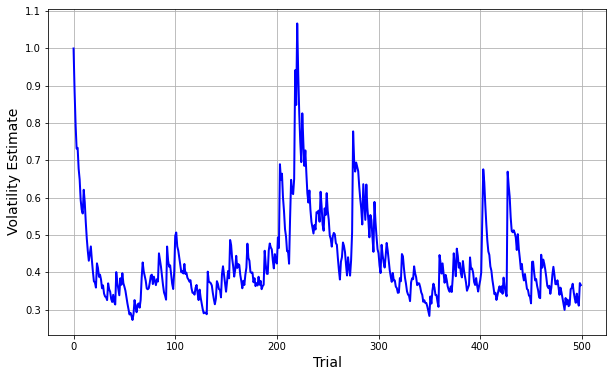

In [6]:
plt.figure(figsize=(10,6)) 
plt.plot(vol,label='True', color='blue', linewidth=2)
plt.grid()
plt.xlabel('Trial', fontsize=14); plt.ylabel('Volatility Estimate', fontsize=14)
plt.savefig('Figures/exp1_vol.png')


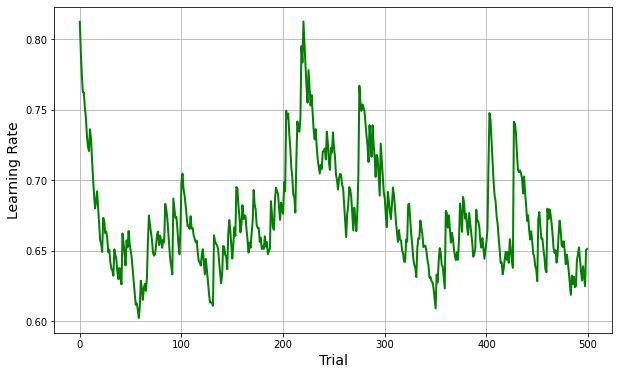

In [7]:
plt.figure(figsize=(10,6)) 
plt.plot(lr,label='True', color='green', linewidth=2)
plt.grid()
plt.xlabel('Trial', fontsize=14); plt.ylabel('Learning Rate', fontsize=14)
plt.savefig('Figures/exp1_lr.png')


In [8]:
from scipy.stats import pearsonr, spearmanr

def pear_spear(signals,plot=False): 
    
    #initialize
    pearson_corr = []; spearman_corr = [] 
    T = len(signals['volatility'])
    
    for i in range(1,int(T/3)):

        window_size = i

        vol = signals['volatility']
        abs_delta = np.abs(signals['prediction_error'])
        ra = np.convolve(abs_delta, np.ones(window_size) / window_size, mode='valid')

        # Calculate correlation coefficients
        pearson_corr.append(pearsonr(vol[window_size-1:], ra)[0])
        spearman_corr.append(spearmanr(vol[window_size-1:], ra)[0])

    #plot correlations as function of window size   
    if plot == True: 
        plt.figure(figsize=(10,6)) 
        plt.xlabel("Bin Size",fontsize=14)
        plt.ylabel("Correlations",fontsize=14)
        plt.plot(pearson_corr, label = 'Pearson Correlation',color = 'mediumblue',alpha=0.9)
        plt.plot(spearman_corr, label = 'Spearman Correlation', color='red',alpha=0.9)
        plt.grid();plt.legend()
        plt.savefig("Figures/correlations1.png")
        plt.show()
    
    #calculate max indexes 
    r_ind = np.where(pearson_corr == max(pearson_corr))[0][0]
    rho_ind = np.where(spearman_corr == max(spearman_corr))[0][0]
    
    return r_ind, pearson_corr, rho_ind, spearman_corr

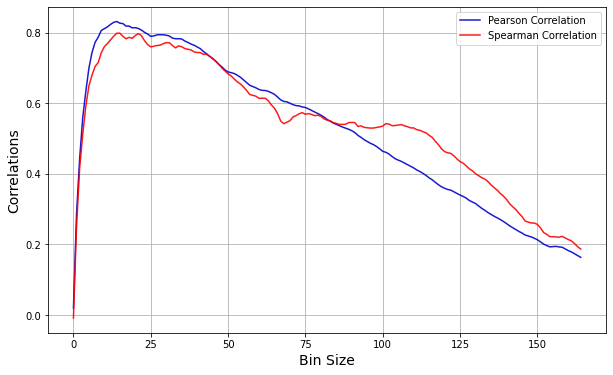

14 15


In [9]:
#plot correlations
cors = pear_spear(signals, plot =True) 
print(cors[0],cors[2])

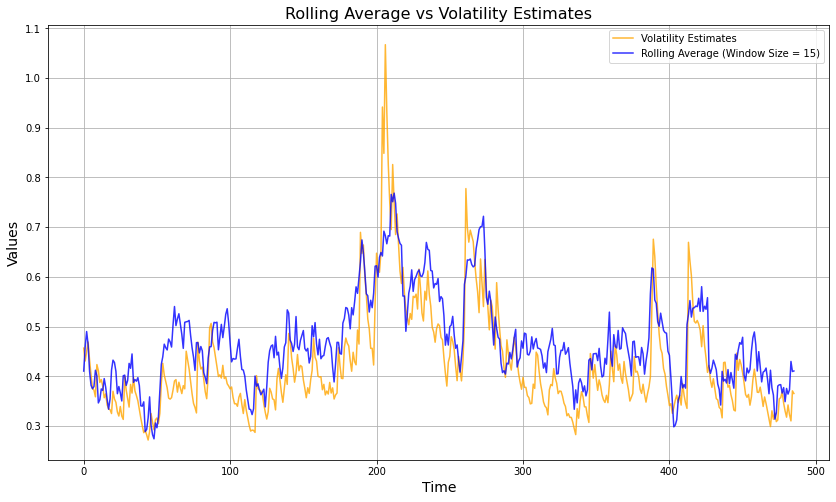

In [10]:
def plot_best_rolling_avg(signals, r_ind):
    # Compute rolling average for the best index
    window_size = r_ind + 1  # Adjust for 1-based index
    abs_delta = np.abs(signals['prediction_error'])
    ra = np.convolve(abs_delta, np.ones(window_size) / window_size, mode='valid')
    
    # Plot rolling average against volatility
    plt.figure(figsize=(14, 8))
    plt.plot(signals['volatility'][window_size-1:], label="Volatility Estimates", color="orange", alpha=0.8)
    plt.plot(ra, label=f"Rolling Average (Window Size = {window_size})", color="blue", alpha=0.8)
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Values", fontsize=14)
    plt.title("Rolling Average vs Volatility Estimates", fontsize=16)
    plt.legend()
    plt.grid()
    plt.savefig("Figures/rolling_vs_volatility.png")
    plt.show()
    
plot_best_rolling_avg(signals, cors[0])


In [11]:
from vkf import VKF

def lambda_rollingavg_analysis(observations, T=200, l_min=1e-2, l_max=1e0, l_num=50, s=0.1, v0=0.1, n_plots=0, sim_every=False): 
        
    #log-spaced lambda values to test 
    l_vals = np.logspace(np.log10(l_min), np.log(l_max), l_num)
    
    #initialize arrays to store
    pear_ind = np.full(l_num,np.nan)
    spear_ind = np.full(l_num,np.nan)
    pear_vals = np.full(l_num,np.nan)
    spear_vals = np.full(l_num,np.nan)
    
    #get plot indices
    if n_plots > 0: 
        spaced_values = np.linspace(0,l_num,int(n_plots))
        plot_indx = np.round(spaced_values).astype(int)
    else: 
        plot_indx = []
    
    #run vkf for every lambda
    for i, l in enumerate(l_vals):
        
        #generate trial
        if sim_every == True:
            observations,s_true,ipv = volatile_walk(T=T)
        
        #generate signals 
        signals = VKF(observations, lambda_=l, v0=v0, s=s)
        
        #find vals
        if i in plot_indx:
            print(l)
            r_max_ind, r_vals, rho_max_ind, rho_vals = pear_spear(signals,plot=True)
        else:
            r_max_ind, r_vals, rho_max_ind, rho_vals = pear_spear(signals)
        
        #update arrays
        pear_ind[i] = r_max_ind
        spear_ind[i] = rho_max_ind
        pear_vals[i] = r_vals[r_max_ind]
        spear_vals[i] = rho_vals[rho_max_ind]
        
        
    correlations = {
        "pearson_indexes": pear_ind,
        "pearson_values": pear_vals,
        "spearman_indexes": spear_ind,
        "spearman_values": spear_vals
    }
        
    return l_vals, correlations

In [12]:
observations,s_true,ipv = volatile_walk(seed=12)
l_vals, cors = lambda_rollingavg_analysis(observations,T=5000,l_min=1e-2,l_num=100)

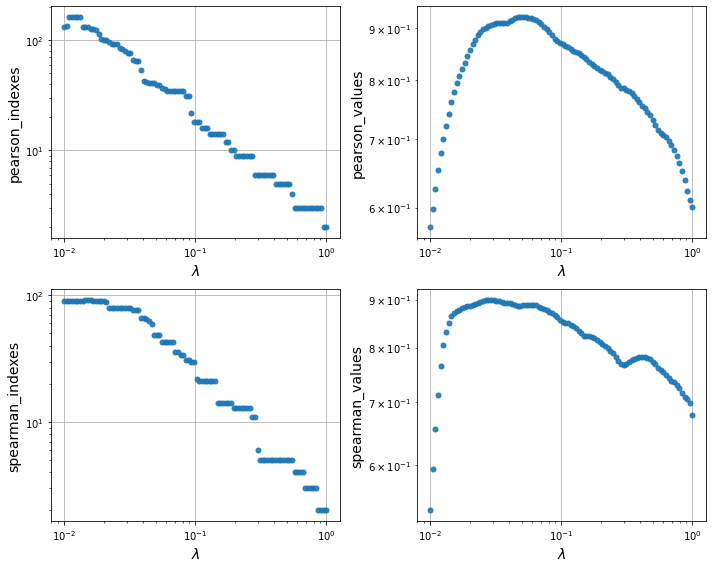

In [13]:
# Create a figure with a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 2 columns

# Flatten the 2D array of axes for easier iteration
axes = axes.flatten()

# Loop through keys and corresponding axes
for i, key in enumerate(cors.keys()):
    ax = axes[i]
    ax.loglog(l_vals, cors[key], 'o', markersize=5, alpha=0.9)
    ax.set_ylabel(key, fontsize=14)
    ax.set_xlabel('$\lambda$', fontsize=14)
    ax.grid()

# Adjust layout to avoid overlap
plt.tight_layout()

#save fig
plt.savefig("Figures/exp1_cors.png")

# Show the complete figure
plt.show()

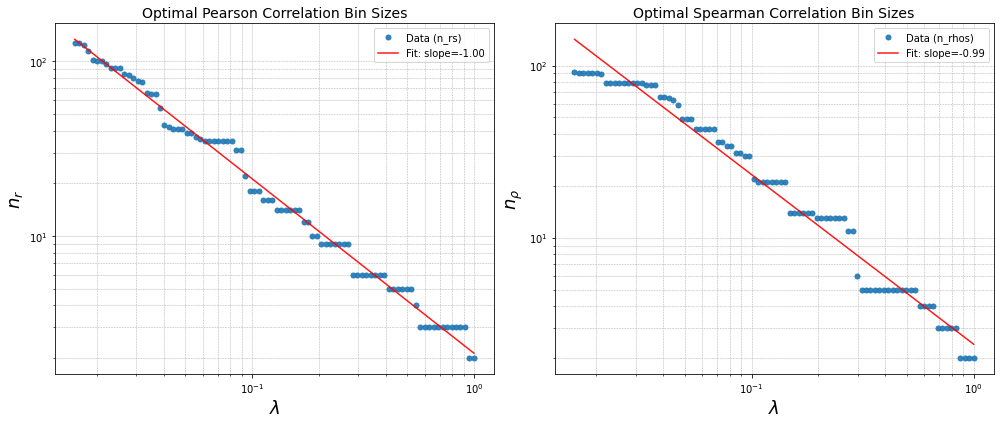

Pearson Correlation:
  Slope: -0.9993850524132197
  Intercept: 0.32884052959074095
  R-squared: 0.9905478909812947
  w*l = 2.1322618152368733

Spearman Correlation:
  Slope: -0.9850794303595366
  Intercept: 0.3815012774604025
  R-squared: 0.9754408123002966
  w*l = 2.407139599547682


In [34]:
from scipy.stats import linregress
n_rs = cors['pearson_indexes']
n_rhos = cors['spearman_indexes']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Pearson Correlation (n_rs)
log_x_rs = np.log10(l_vals)[10:]
log_y_rs = np.log10(n_rs)[10:]
slope_rs, intercept_rs, r_value_rs, _, _ = linregress(log_x_rs, log_y_rs)

axes[0].loglog(l_vals[10:], n_rs[10:], 'o', markersize=5, alpha=0.9, label="Data (n_rs)")
regression_line_rs = 10**(slope_rs * log_x_rs + intercept_rs)
axes[0].loglog(l_vals[10:], regression_line_rs, color="red", alpha=0.9, label=f"Fit: slope={slope_rs:.2f}")
axes[0].set_title("Optimal Pearson Correlation Bin Sizes", fontsize=14)
axes[0].set_xlabel('$\lambda$', fontsize=18)
axes[0].set_ylabel('$n_r$',fontsize=18)
axes[0].legend()
axes[0].grid(True, which="both", linestyle="--", linewidth=0.5)

# Spearman Correlation (n_rhos)
log_x_rhos = np.log10(l_vals)[10:]
log_y_rhos = np.log10(n_rhos)[10:]
slope_rhos, intercept_rhos, r_value_rhos, _, _ = linregress(log_x_rhos, log_y_rhos)

axes[1].loglog(l_vals[10:], n_rhos[10:], 'o', markersize=5, alpha=0.9, label="Data (n_rhos)")
regression_line_rhos = 10**(slope_rhos * log_x_rhos + intercept_rhos)
axes[1].loglog(l_vals[10:], regression_line_rhos, color="red", alpha=0.9, label=f"Fit: slope={slope_rhos:.2f}")
axes[1].set_title("Optimal Spearman Correlation Bin Sizes", fontsize=14)
axes[1].set_xlabel('$\lambda$', fontsize=18)
axes[1].set_ylabel('$n_\\rho$',fontsize=18)
axes[1].legend()
axes[1].grid(True, which="both", linestyle="--", linewidth=0.5)

# Show the plots
plt.tight_layout()
plt.savefig("Figures/regression1.png")
plt.show()

# Print regression details
print("Pearson Correlation:")
print(f"  Slope: {slope_rs}")
print(f"  Intercept: {intercept_rs}")
print(f"  R-squared: {r_value_rs**2}")
print(f"  w*l = {10**intercept_rs}")

print("\nSpearman Correlation:")
print(f"  Slope: {slope_rhos}")
print(f"  Intercept: {intercept_rhos}")
print(f"  R-squared: {r_value_rhos**2}")
print(f"  w*l = {10**intercept_rhos}")